# Lecture III: Recurrent Neural Network
This homework aims to help you understand Recurrent Neural Network by building a RNN classifier on Japanese Vowels from different male speakers. 

As usual, we will first import some useful modules:

In [4]:
# pylint: disable=E1101,R,C
import numpy as np
import os
import argparse
import time
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.autograd import Variable
import gzip
import pickle
from scipy import sparse
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast 
torch.set_default_tensor_type(torch.FloatTensor)

The Japanese Vowel dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels). For a detailed description, please look at this website. First, we will download the dataset:



## Part I: Dataset

First, we will need to prepare the dataset using `Dataset()` class. Since in last home work, I have gone through the detail of this class, I will skip most of the technical details.

In [5]:
train_set = np.genfromtxt('Data/trainset.csv', delimiter =',')
train_times = np.genfromtxt('Data/traintime.csv', delimiter =',')
test_set = np.genfromtxt('Data/testset.csv', delimiter =',')
test_time = np.genfromtxt('Data/testtime.csv', delimiter =',')

print(len(train_set))
print(train_times)
#print(test_set)
#print(test_time)
        



527
[ 20.69640749  12.49160129  24.87724295  25.58417521  21.85737757
  29.93421177   6.48259552  12.10224866  18.95794343  -3.39923022
  16.47625537  28.21717346  19.68067048  19.66405462  33.78130839
  32.13720559  23.85811329  10.43540995  32.1748495   34.54179998
  15.62110523  27.01119928   7.99301531  19.43367157  13.86479272
  36.97901539  22.66974866  17.78317946  19.08155747  29.65354205
  15.78098796  15.84854155  25.46079154  30.32612992  14.63288393
  21.74344057  33.79448107  24.41764471  44.47351209  24.32699009
   4.1478825   13.02870198  15.3169417   17.22838704  12.15771544
  25.87306092  26.31469394   7.98849911  10.02400722  10.45550932
  27.21654872   8.95515357  36.53089883  15.43384054  26.69411944
   5.20009154  16.90879131  20.69187271  29.26594775  29.15464614
   1.28644073   7.4431767    4.12080516   5.30470406  14.01285359
  25.38009552  35.91912632  24.35259713   6.19132531  34.96214014
  19.38028475  22.07056478  -0.46613969  28.77499487  25.65353207
  30.4

In [6]:
class JapaneseVowelDataset(Dataset):

    def __init__(self,plot=True):
        
        self.max_length = 250 # The maximum possible length of wave contains 250 samples
        self.num_LPC = 1   # The LPC spectrum contains 1 coefficients, so the data shape will be [250,1]
        
        # Load the waveforms with the truth
        
        train_data = np.genfromtxt('Data/trainset.csv', delimiter =',')
        train_label = np.genfromtxt('Data/traintime.csv', delimiter =',')
        test_data = np.genfromtxt('Data/testset.csv', delimiter =',')
        test_label = np.genfromtxt('Data/testtime.csv', delimiter =',')
        

        self.size = len(train_data) + len(test_data)
        self.train_test_split = len(train_data)
        
        self.data = np.concatenate([train_data, test_data], axis=0) #(for equal dimensions)
        self.labels = np.concatenate([train_label, test_label], axis=0)
        
        
        if plot:
            self.plot_data()
        
    def __len__(self):
        '''
        This function returns the size of overall dataset
        '''
        return self.size
    
    
    def __getitem__(self, idx):
        '''
        This function extract a single entry from the dataset at the given index idx
        In this dataset, the data has variable length, so we need to pad 
        the LPC coefficients to have the same length for training purpose
        '''
        output = np.zeros((self.max_length, self.num_LPC)) #[250,1] dimension
        data = self.data[idx]
        output[:data.shape[0], :] += data.reshape(-1, 1)
        return output, self.labels[idx]
    
    def plot_data(self):
    
        plt.figure(figsize=(20,12))
        sample_index = np.random.randint(low=0, high=self.__len__(), size=9)
        voices = []
        for i in range(9):
            voice, label = self.__getitem__(sample_index[i])
            voices.append(voice)
        voices = np.concatenate(voices, axis=1)
        utt_length = voices.shape[0]
        for i in range(voices.shape[-1]):
            plt.plot(np.arange(utt_length), voices[:,i])
            
        #how to add the vertical lines where each time t0 is for a wave?
        
        plt.xlabel("Time Index")
        plt.ylabel("Voltage")
        plt.show()

In [7]:
#def read_vowels(self, file, size_file):
        #vowel_units = [] #Waveforms
       # labels = [] #Truth (time)
        
        # Read in the vowel waveform data
        #with open(file, "r") as f:
           # current_vowel = []
            #for line in f.readlines():
                #if line == '\n':
                  #  vowel_units.append(np.array(current_vowel))
                    #current_vowel = []
                    #continue
                #current_vowel.append(np.array(line.strip().split(" "),dtype=float).tolist())
                
        # Read in the sizes of each vowel waveform
        #with open(size_file, "r") as f:
            #for line in f.readlines():
                #labels.append(int(line.strip()))
                
        #assert len(vowel_units) == len(labels)
        #return vowel_units, labels
            



In [8]:
#print(train_set)
#print(train_times)
#print(test_set)
#print(test_time)
        

Similarly, we can check the form of data by plotting the LPC spectrum coefficients. The trailing 0s comes from the padding we performed within the dataset:

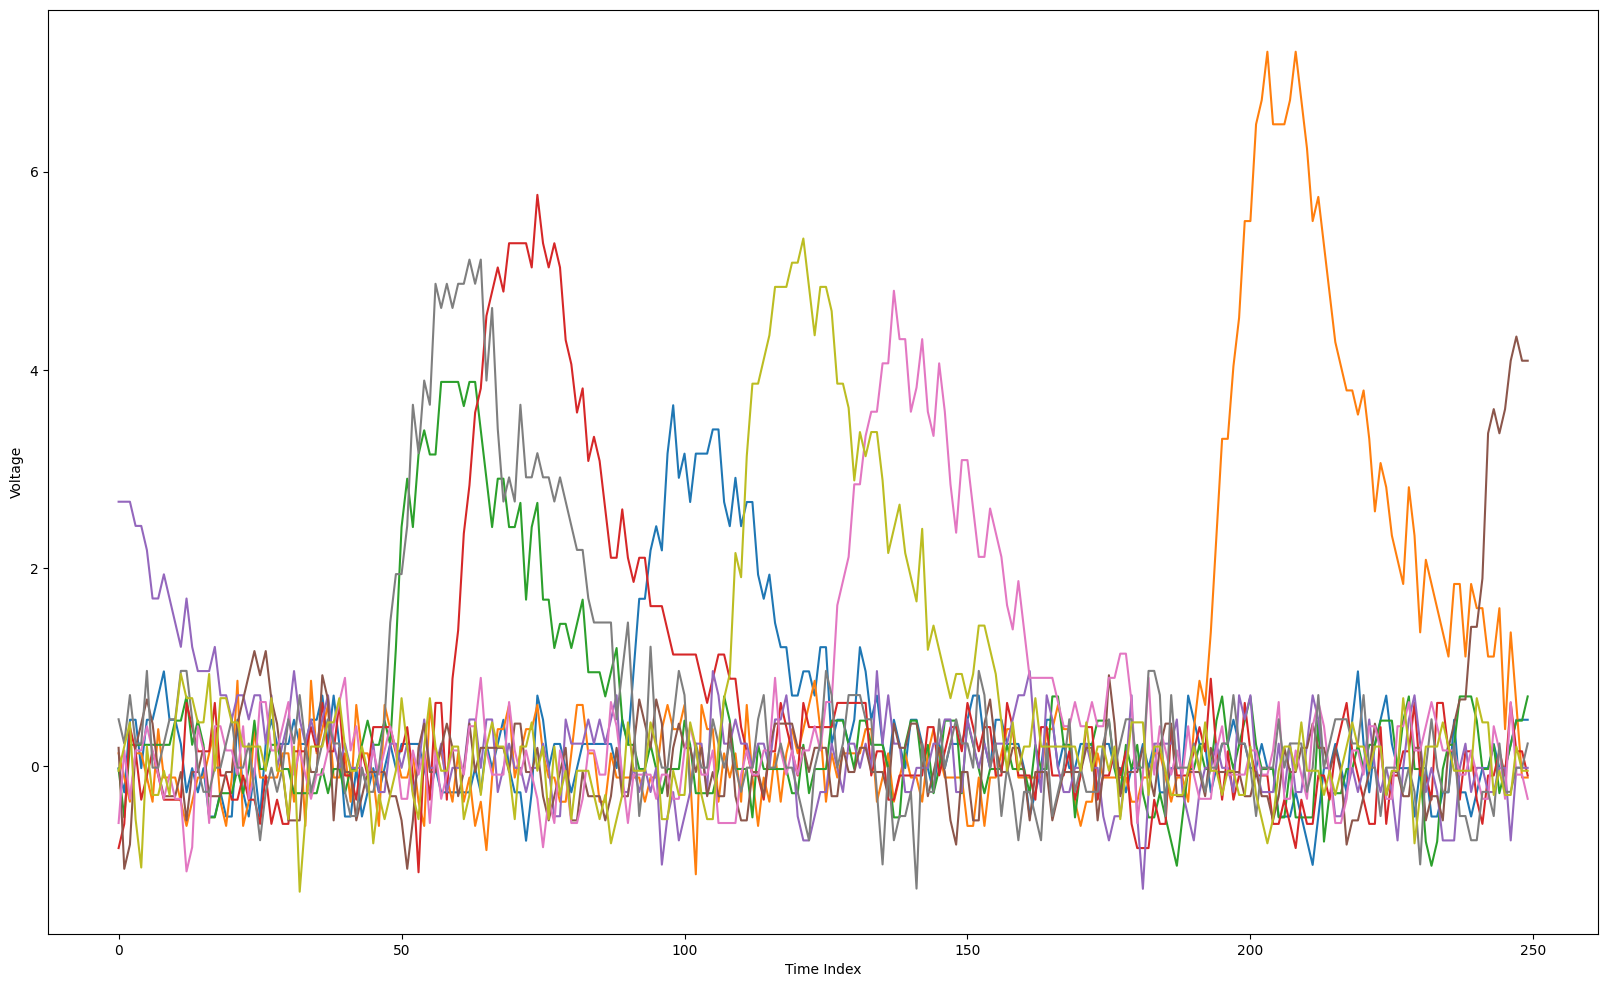

In [ ]:
JapaneseVowelDataset()

## Part II: Recurrent Neural Network
In this part, we will buid an LSTM based recurrent neural network model to analyze the input LPC spectrum. Since this is the second time we build a NN, I will leave most of the work to you. Some useful resources include:
- [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm)
- [nn.Linear](https://pytorch.org/docs/master/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)
- [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html?highlight=leakyrelu#torch.nn.LeakyReLU)
- [nn.Sequential](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential)

Some useful tips for building the recurrent neural network:
- Read [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm) carefully, make sure you understand the input and output shape of the LSTM layer. The [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm) layer outputs `output, (h_n, c_n)`:
    -  `output` has a shape of `(Seq_len,Batch_size,num_direction*hidden_size)`, it contains all intermediate hidden state outputs of the last layer. Note that there is a `batch_first` flag in LSTM input which may change the output shape to `(Batch_size,Seq_len,num_direction*hidden_size)`. If you want to select only the last hidden state, you shoud simply index the `Seq_len` dimension.
    -  `(h_n, c_n)` contains the last hidden state outputs of each layers
- Remember that you want to select only the the **last hidden state output**. You can either extract it from `output` or `h_n`.
- Then you will feed the **last hidden state output** into `self.fc_classifier`. You will need to adjust the `hidden_size` of LSTM output and the input size of first fully connected layer in `self.fc_classifier` to match
- Make sure the output of RNN model has the shape of [BATCHSIZE,9], since we have 9 speakers in the dataset we'd like to classify into

In [11]:
'''
This script contains the PositionalUNet network along with 3 candidate discriminators:
* RNN+Attention discriminator
* CNN+PositionalEncoding Discriminator
* Fully Connected Discriminators
we have tested all 3 discriminators, turns out that the RNN+Attention works the best
'''

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import math



class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=11, padding=5,bias=False),
            nn.BatchNorm1d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(mid_channels, out_channels, kernel_size=7, padding=3,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels, pool=True):
         super().__init__()
        self.pool = pool
        self.pool_layer = nn.MaxPool1d(2)
        self.maxpool_conv = nn.Sequential(
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        if self.pool:
            x = self.pool_layer(x)
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose1d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]

        x1 = F.pad(x1, [diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        mid_channels = int(in_channels + out_channels)//2
        self.conv = nn.Sequential(
            torch.nn.Conv1d(in_channels, mid_channels, kernel_size=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(mid_channels, out_channels, kernel_size=1),
             )
    # @torchsnooper.snoop()
    def forward(self, x):
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.bilinear = True
        
        multi = 40
        
        self.inc = DoubleConv(12, multi) #1 instead of 12 for feeding 1 wave form at a time --> input channels 
        self.down1 = Down(multi, multi*2)
        self.down2 = Down(multi*2, multi*4)
        self.down3 = Down(multi*4, multi*8)
        factor = 2 if self.bilinear else 1
        self.down4 = Down(multi*8, multi*16 // factor,pool=False)
        
       
        
        self.up1 = Up(multi*16, multi*8 // factor, self.bilinear)
        self.up2 = Up(multi*8, multi*4 // factor, self.bilinear)
        self.up3 = Up(multi*4, multi*2 // factor, self.bilinear)
        self.up4 = Up(multi*2, multi // factor, self.bilinear)
        self.outc = OutConv(multi // factor, 10) # This 2 is number of decisions we want it to make. In the vowel case we only want 2 decisions (0/non0), in waveform case we may need more
        self.softmax = torch.nn.Softmax(dim=-1)
        #self.sigmoid = torch.Sigmoid()
    
    # @torchsnooper.snoop()
    def forward(self, x):
        x = x.transpose(1,1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x5 = self.down4(x4)
        
        #Two inputs in the next ones because of the contraction paths 
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        
        output = output.transpose(1,1)
        # output = self.softmax(output)
        output = torch.sigmoid(output)
        
        return output


Similar to what we did in Lecture 2 homework, we will pull out 1 event from the dataset, and use `torchsnooper.snoop()` to check the network structure. Before proceeding to the next part, you may want to stare at the tensor output of `torchsnooper.snoop()` carefully to understand how the data is flowing within the RNN network.

In [15]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(JapaneseVowelDataset(plot=False)))
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
test_network = UNet()
print(test_network(test_event))

RuntimeError: Given groups=1, weight of size [40, 12, 11], expected input[1, 250, 1] to have 12 channels, but got 250 channels instead

## Part III: Training
After building the neural network, we train it the same way as we did in Lecture 2:

In [16]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This says if GPU is available, use GPU, otherwise use CPU
NUM_EPOCHS =20
LEARNING_RATE =1e-3 # 1e-2 is a good learning rate for general purpose
BATCH_SIZE=5

In [17]:
def set_up_classifier():
    classifier = UNet() # Define CNN neural network classifier
    classifier.to(DEVICE)     # Send the classifier to DEVICE as we defined earlier

    print("# of params in model: ", sum(x.numel() for x in classifier.parameters()))

    criterion = torch.nn.BCELoss()
    criterion = criterion.to(DEVICE)

    #Define the optimizer
    optimizer = torch.optim.Adam(classifier.parameters(),lr=LEARNING_RATE)
    
    return classifier, criterion, optimizer

In [18]:
def get_dataloader():
    dataset = JapaneseVowelDataset(plot=False)
    #Get the indices of train dataset and test dataset correspondingly, indices [0:train_test_split] is the training dataset, indices [train_test_split, len(dataset)] is the test dataset.
    train_test_split = dataset.get_train_test_split()
    train_indices, val_indices = list(range(train_test_split)), list(range(train_test_split,len(dataset)))

    #Shuffle the two indices list
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    # Define two subset random sampler to sample events according to the training indices
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    # Finally, define the loader by passing in the dataset, batch size and corresponding sampler
    # Note that the number of data in each sub-dataset might not be divisibe by the batch size, so drop_last=True drops the last batch with all the residual events.
    train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE,sampler=valid_sampler,  drop_last=True)
    
    return train_loader, test_loader

In [19]:
classifier, criterion, optimizer = set_up_classifier()
train_loader, test_loader = get_dataloader()

loss_values = []
accuracy_values = []
y_true = []
y_pred = []

for epoch in range(NUM_EPOCHS):
    for i, (utterances, labels) in tqdm(enumerate(train_loader)):
        # utterances.shape = [5,29,12]
        # SS label size = [5,29,2]
        label_array = []
        for utt in utterances:
            first_dim = utt[:,0] != 0 # shape: (29,)
            second_dim = utt[:,0] == 0 # shape: (29,)
            label_vector = np.concatenate([first_dim[:,None], second_dim[:,None]],axis=-1)
            label_array.append(label_vector[None,:])
        labels = torch.Tensor(np.concatenate(label_array, axis=0))
        classifier.train() # This line set the neural network to train mode, some layers perform differently in train and test mode.
        
        utterances = utterances.to(DEVICE).float()
        labels = labels.to(DEVICE)
        
        #Train the RNN classifier
        outputs  = classifier(utterances)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Back-propagate loss to update gradient
        loss.backward()
        
        # Perform gradient descent to update parameters
        optimizer.step()
        
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()

    print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        loss.item(), end=""),end="")
    loss_values.append(loss.item())
    
    #After every epoch, evaluate the validation accuracy on the test loader
#     num_accurate = 0
#     num_images = 0
#     for utterances,labels in tqdm(test_loader):

#         classifier.eval() # This line set the neural network to evaluation mode, some layers perform differently in train and test mode.
        
#         #While validating the network, we do not want it to produce any gradient. This will also save us time/memory
#         with torch.no_grad():
            
#             # Convey images to device, then feed it to the neural network for network output
#             utterances = utterances.to(DEVICE).float()
#             outputs  = classifier(utterances)
            
#             # Get classification decision by reading out the maximum value on the 10-dimensional vector
#             decision = torch.argmax(outputs, dim=-1)
#             decision = decision.cpu().data.numpy().flatten() # copy decision to CPU and convert it to a numpy array
#             labels = labels.cpu().data.numpy().flatten()
            
#             # Update the list of truth value and network predictions in last epoch:
#             if epoch == (NUM_EPOCHS-1):
#                 y_true += list(labels)
#                 y_pred += list(decision)
            
#             #Calculate accuracy by # of correct prediction / total numbers

#             num_accurate += np.sum((decision - labels) == 0)
#             num_images += len(decision)
#     accuracy_values.append(num_accurate/num_images)  


# of params in model:  7013635


AttributeError: 'JapaneseVowelDataset' object has no attribute 'get_train_test_split'

In [20]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(JapaneseVowelDataset(plot=False)))
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
#print(test_event.size, test_event)
test_network = classifier
test_network.eval()
decision = torch.softmax(test_network(test_event),dim=-1)
print(decision)
test_event = test_event.detach().numpy()
decision = decision.detach().numpy()
plt.plot(test_event[0,:,:])
#plt.plot(decision[0,:,:])
matplotlib.pyplot.fill_between(np.arange(29),0, decision[0,:,0], color = 'blue', alpha = 0.3)
matplotlib.pyplot.fill_between(np.arange(29),0, decision[0,:,1], color = 'grey', alpha = 0.3)
plt.show()

RuntimeError: Given groups=1, weight of size [40, 12, 11], expected input[1, 250, 1] to have 12 channels, but got 250 channels instead